In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [1]:
%matplotlib inline
import my_utils as mu
import math
import torch
from torch import nn
from torch.nn import functional as F

# Desired Features of RNNs

  
* Have a mechanism for storing vital early information in a *memory cell*. 
    * An early observation is highly significant for predicting all future observations.
    * Without such a mechanism, we will have to assign a very large gradient to this observation
* Handle situations where some symbols carry no pertinent information and have a mechanism for *skipping such symbols* in the latent state representation. 
  * E.g. when parsing a web page there might be auxiliary HTML code that is irrelevant for the purpose of assessing the sentiment conveyed on the page.  
* Have a mechanism of *resetting* our internal state representation.
    * When there is a logical break between parts of a sequence, e.g. a transition between chapters in a book.

# LSTMs and GRUs

* The Long Short Term Memory (LSTM) is an Advanced RNN which can handle all of the above requirements.
* The Gated Recurrent Unit (GRU) is a simplied version of LSTM.
    * Due to its simplicity, we will start with the GRU.



# Gated Recurrent Units (GRU)


## Gating the Hidden State

* The key distinction between regular RNNs and GRUs is that the latter support gating of the hidden state. 
    * This means that we have dedicated mechanisms for when a hidden state should be updated and also when it should be reset. 
    
* These mechanisms are learned: 
     * E.g., if the first symbol is of great importance, it will learn not to update the hidden state after the first observation. 
     * Likewise, it will learn to skip irrelevant temporary observations. 
     * Last, it can learn to reset the latent state whenever needed. 


# Reset Gates and Update Gates

* The first thing we need to introduce are reset and update gates.  
* A reset gate would allow us to control how much of the previous state we might still want to remember.
* An update gate would allow us to control how much of the new state is just a copy of the old state.
* We engineer them to be vectors with entries in $(0, 1)$.

* The following figure shows how the reset and update gates are computed a each time step: 
  * They are functions of $\mathbf{X}_t$ and $\mathbf{H}_{t-1}$. 
  * The function output is given by a fully connected layer with a sigmoid as its activation function.

![ Reset and update gate in a GRU. ](img/gru_1.svg)

<!-- ![Reset and update gate in a GRU. ](https://drive.google.com/uc?export=view&id=1g_auUeCt5EQXCRWUTpdBuE0V_EyqtmiY)-->    




* Assume, for a given time step $t$, the minibatch input is $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$, number of inputs: $d$) and the hidden state of the last time step is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (number of hidden states: $h$). 

* Then, the reset gate $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ and update gate $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ are computed as follows:

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z).
\end{aligned}
$$

* $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ are
biases. 
* A sigmoid function is used to transform input values to the interval $(0, 1)$.

# Reset Gates in Action

* In a conventional RNN, we would have an hidden state update of the form

$$\mathbf{H}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1}\mathbf{W}_{hh} + \mathbf{b}_h).$$


* If we want to reduce the influence of the previous states we can multiply $\mathbf{H}_{t-1}$ with $\mathbf{R}_t$ elementwise. 
    * For all entries of $\mathbf{R}_t$ that are close to $1$, we recover a conventional RNN. 
    * For all entries of $\mathbf{R}_t$ that are close to $0$, the pre-existing hidden state is reset to defaults. 
        
* This leads to the following *candidate hidden state*:

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h).$$



* The following figure illustrates the computational flow after applying the reset gate. 
  * The symbol $\odot$ indicates elementwise multiplication between tensors.

![ Candidate hidden state computation in a GRU. The multiplication is carried out elementwise. ](img/gru_2.svg) 

<!-- ![ Candidate hidden state computation in a GRU. The multiplication is carried out elementwise. ](https://drive.google.com/uc?export=view&id=1LE9q5hFWtIKuySB_fKPkiBepoDyUA7CR) -->   


# Update Gates in Action

* The update gate $\mathbf{Z}_t$, determines the extent to which the new state $\mathbf{H}_t$ is just the old state $\mathbf{H}_{t-1}$ and by how much the new candidate state $\tilde{\mathbf{H}}_t$ is used. 

* This leads to the final update equation for the GRU:

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$

* Whenever $\mathbf{Z}_t$ is close to $1$, we simply retain the old state. 
    * In this case $\mathbf{X}_t$ is essentially ignored, effectively skipping time step $t$ in the dependency chain. 
* Whenever $\mathbf{Z}_t$ is close to $0$, the new latent state $\mathbf{H}_t$ becomes the candidate latent state $\tilde{\mathbf{H}}_t$.



* Put everything together the GRU is shown in the following figure:

![ Hidden state computation in a GRU. As before, the multiplication is carried out elementwise. ](img/gru_3.svg)

<!-- ![ Hidden state computation in a GRU. As before, the multiplication is carried out elementwise. ](https://drive.google.com/uc?export=view&id=1_ZTvSMWMGvQruQent0FRKIgJ_7m9YqPE) -->   

* In summary, GRUs have the following two distinguishing features:
    * Reset gates help capture short-term dependencies in time series.
    * Update gates help capture long-term dependencies in time series.

* These designs help with:
    * Cope with the vanishing gradient problem in RNNs  
    * Better capture dependencies for time series with large time step distances. 


# Concise Implementation of GRU 

# Loading the Dataset


In [8]:
batch_size, num_steps = 32, 35
train_iter, vocab = mu.load_data_time_machine(batch_size, num_steps)

In [17]:
# RNNModel class contains a complete RNN model.
# rnn_layer only contains the hidden recurrent layers, we need to create a separate output layer.
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size):
        super(RNNModel, self).__init__()
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        #print(X.size()) # 35x32x28
        #print(Y.size()) # 35x32x256
        #print(state.size()) # 32x256
        Y1 = Y.reshape((-1, Y.shape[-1]))
        #print(Y1.size()) # 1120x256
        out = self.linear(Y1) 
        #print(out.size()) # 1120x28
        return out, state

    def begin_state(self, batch_size=1):
        state = torch.zeros((self.rnn.num_layers, batch_size, self.num_hiddens))
        return state 

In [25]:
def train_epoch_ch8(model, train_iter, loss, optimizer, use_random_iter):
    """Train a model for one epoch """
    state = None
    metric = mu.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        # Initialize `state` when first iteration or using random sampling
        if state is None or use_random_iter:
            state = model.begin_state(batch_size=X.shape[0])
        else:
            if isinstance(model, nn.Module) and not isinstance(state, tuple):
            # `state` is a tensor for `nn.GRU`
                state.detach_()
        #print(X.size(), Y.size(), state.size()) # 32x35, 32x35, 32x256
        y = Y.T.reshape(-1) 
        #print(y.size()) # 35x32 -> 1120 
        y_hat, state = model(X, state)
        #print(y_hat.size()) # 1120x28 
        l = loss(y_hat, y.long())
        optimizer.zero_grad()
        l.backward()
        mu.grad_clipping(model, 1)
        optimizer.step()
    
        metric.add(l * mu.size(y), mu.size(y))
    return math.exp(metric[0] / metric[1])

In [26]:
def train_ch8(model, train_iter, vocab, lr, num_epochs, use_random_iter=False):
    """Train a model for num_epochs"""
    animator = mu.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[1, num_epochs])
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch_ch8(model, train_iter, loss, optimizer, use_random_iter)
        if epoch % 10 == 0:
            print(predict_ch8('time traveller', 50, model, vocab))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}')
    print(predict_ch8('time traveller', 50, model, vocab))
    print(predict_ch8('traveller', 50, model, vocab))

In [27]:
def predict_ch8(prefix, num_preds, model, vocab):  
    """Generate new characters following the `prefix`."""
    state = model.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: mu.reshape(torch.tensor([outputs[-1]]), (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = model(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# Training and Prediction


perplexity 1.0
time traveller  it s against reason said filby  what reason said
traveller  it s against reason said filby  what reason said


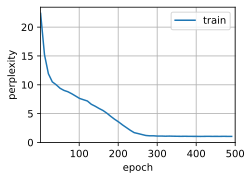

In [28]:
vocab_size, num_hiddens = len(vocab), 256
num_epochs, lr = 500, 1
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
train_ch8(model, train_iter, vocab, lr, num_epochs)

# Summary

* Gated recurrent neural networks are better at capturing dependencies for time series with large time step distances.
* Reset gates help capture short-term dependencies in time series.
* Update gates help capture long-term dependencies in time series.
* GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. They can ignore sequences as needed.
